In [246]:
import numpy as np
import scipy as sp
import math
import random
import time
import matplotlib.pyplot as plt
import matplotlib.cm as cm

### States

In [4]:
zero  = np.array([[1], [0], [0], [0], [0], [0]],dtype=complex)
one   = np.array([[0], [1], [0], [0], [0], [0]],dtype=complex)
two   = np.array([[0], [0], [1], [0], [0], [0]],dtype=complex)
three = np.array([[0], [0], [0], [1], [0], [0]],dtype=complex)
four  = np.array([[0], [0], [0], [0], [1], [0]],dtype=complex)
five  = np.array([[0], [0], [0], [0], [0], [1]],dtype=complex)

### Permutations

In [5]:
SN = - zero@zero.T - one@one.T + five@two.T \
     +four@three.T+three@four.T+ two@five.T

SS =  -zero@zero.T - one@one.T + five@three.T \
     +four@two.T+two@four.T+ three@five.T

SE =  -two@two.T - three@three.T + five@one.T \
     +four@zero.T+zero@four.T+ one@five.T

SW = - two@two.T - three@three.T + five@zero.T \
     +four@one.T+one@four.T+ zero@five.T

D1 = zero@three.T + three@zero.T +one@two.T + two@one.T \
     -four@four.T - five@five.T

D2 = zero@two.T + two@zero.T +one@three.T + three@one.T \
     -four@four.T - five@five.T

rot_CW = zero@three.T + three@one.T + one@two.T + two@zero.T + four@five.T + five@four.T

rot_CCW = rot_CW.T

flip_V = zero@zero.T + one@one.T + three@two.T + two@three.T + four@five.T + five@four.T

flip_H = zero@one.T + one@zero.T + three@three.T + two@two.T + four@five.T + five@four.T

Id = zero@zero.T + one@one.T + two@two.T + \
     three@three.T + four@four.T + five@five.T

### Gate Set (S)

In [235]:
Perms = [SN,SS,SE,SN]#D1,D2,flip_H,flip_V,rot_CW,rot_CCW]
SQRT_SWAP = [(Id + 1j*P)/np.sqrt(2) for P in Perms]
Quarter_Swap = [np.cos(np.pi/8)*Id + np.sin(np.pi/8)*1j*P for P in Perms]

# Quantum agent's moves
QS = []
for move in SQRT_SWAP:
    repeat = move
    QS.append(repeat)
    for i in range(3):
        repeat = move @ repeat
        QS.append(repeat)

# Classical agent's moves
CS = Perms


## Scrambling

In [42]:
Num_scrambles = 50
min_length = 10
max_length = 100
Scrambles = []
for i in range(Num_scrambles):
    l = random.randint(min_length,max_length)
    move_list = random.choices(QS,k=l)
    state = zero
    for move in move_list:
        state = move @ state
    Scrambles.append(state)


## Rules

asdf

### The move expectation

In [89]:
def E_N(state,moves,Costs=[1,0,1,1]):
    P_solve = np.abs(state[0])**2
    meas_cost = Costs[0]
    failure_penalty = Costs[1]
    initial_move_cost = Costs[2]
    move_cost_after_failure = Costs[3]
    #print(P_solve)
    return ((meas_cost+(move_cost_after_failure*moves+failure_penalty)*(1-P_solve))/P_solve + initial_move_cost*moves)[0]
   # return ((meas_cost+(move_cost_after_failure*moves+failure_penalty)*(1-P_solve))/P_solve + initial_move_cost*moves)[0]

## Greedy Strategy

In [106]:
def Greedy(move_set,scramble,Costs=[1,0,1,1]):
    state = scramble
    m = 0
    solve = []
    while True:
        best = E_N(state,m,Costs)
        next_move = []
        flag = True
        for move in move_set:
            new_state = move@state
            if E_N(new_state,m+1,Costs)< best:
                next_move = move
                best = E_N(new_state,m+1,Costs)
                flag = False
        if flag:
            break
        m += 1
        state = next_move@state
        solve.append(next_move)
        print(m)
    return [solve,state,E_N(state,m,Costs)]
        

In [145]:
Costs = [1,5,0,0]
[solve,state,E] = Greedy(QS,Scrambles[1],Costs)
E

1


9.769230769231342

## Optimal fixed depth strategy

In [ ]:
def fixed_depth(move_set,scramble,depth,Costs): # implemented with some redundancy
    state = scramble
    states = [state]
    best = E_N(scramble,0,Costs)
    best_state = state
    best_depth = 0
    for i in range(depth):     
        new_states=[]
        for move in move_set:
            for state in states:
                new_state = move@state
                new_states.append(new_state)
                if(E_N(new_state,i+1,Costs)< best):
                    best = E_N(new_state,i+1,Costs)
                    best_state= new_state
                    best_depth = i+1
        for state in new_states:
            states.append(state)
    return [best_state,best,best_depth]

In [196]:
Costs = [1,1000,1,0]
start_time = time.perf_counter()

[state,E,d] = fixed_depth(QS,Scrambles[1],5,Costs)
print(E,d)
end_time = time.perf_counter()
execution_time = end_time - start_time
print(f"The execution time is: {execution_time}") 

here
here
here


/var/folders/cl/131my1d14z537kcq7ydt4xyc0000gp/T/ipykernel_15855/2872762272.py:8: RuntimeWarning: divide by zero encountered in true_divide
  return ((meas_cost+(move_cost_after_failure*moves+failure_penalty)*(1-P_solve))/P_solve + initial_move_cost*moves)[0]


here
here
6.000000000040008 5
The execution time is: 136.81970867199925


## Trying to improve performance with less stupid enumeration

### Helper functions

In [211]:
def hash_func(state):
    string = ''
    temp = np.round(canonical_phase(state),8)
    for coeff in temp:
        if np.real(coeff) == 0 :
            string += '[0.]'
        else:
            string +=   str(np.real(coeff))
        if np.imag(coeff) == 0:
            string += '[0.]'
        else:
            string += str(np.imag(coeff))
        
    return string

def canonical_phase(state):
    #phase choosen so that the first nonzero element is positive
    for coeff in state:
        if not math.isclose(np.abs(coeff),0):
            phase = np.angle(coeff)
            break
    return state / np.exp(1j*phase)


import copy

def state_enum(scramble,move_set,max_depth):# returns all states that can be gotten to with depth moves from scramble
    group = {hash_func(scramble):scramble}
    new_elems = group
    depth = 0
    states = []
    depths = []
    while(depth<max_depth):
        current_group = new_elems.copy()
        new_elems = {}
        for g in move_set:
            # iterate through the group
            for key in current_group: 
                state = g@current_group[key]
                hashed = hash_func(state)
                if not (hashed in group):
                    new_elems.update({hashed:state}) 
                    group.update({hashed:state})
                    states.append(state)
                    depths.append(depth+1)
        depth += 1
    return [states,depths]

### Using smart enumeration

In [243]:
def fixed_depth_enum(move_set,scramble,depth,Costs): # implemented with some redundancy
    [states,depths] = state_enum(scramble,move_set,depth)
    best = E_N(scramble,0,Costs)
    best_state = scramble
    best_depth = 0
    for i,state in enumerate(states):
        if(E_N(state,depths[i],Costs)< best):
                    best = E_N(state,depths[i],Costs)
                    best_state = state
                    best_depth = depths[i]
    return[best_state,best,best_depth]

In [237]:
Costs = [1,10,1,1]
start_time = time.perf_counter()

[state_2,E,d] = fixed_depth_enum(QS,Scrambles[4],5,Costs)
print(E,d)
end_time = time.perf_counter()
execution_time = end_time - start_time
print(f"The execution time is: {execution_time}") 

8.42673521850989 3
The execution time is: 11.495820238000306


In [238]:
Costs = [1,10,1,1]
start_time = time.perf_counter()

[state,E,d] = fixed_depth_enum(CS,Scrambles[4],4,Costs)
print(E,d)
end_time = time.perf_counter()
execution_time = end_time - start_time
print(f"The execution time is: {execution_time}") 

28.40000000000183 1
The execution time is: 0.044662453001365066


## Averaging over many scrambles

In [285]:
Num_scrambles = 300
min_length = 10
max_length = 100
Scrambles = []
for i in range(Num_scrambles):
    l = random.randint(min_length,max_length)
    move_list = random.choices(QS,k=l)
    state = zero
    for move in move_list:
        state = move @ state
    Scrambles.append(state)

In [286]:
start_time = time.perf_counter()
Costs = [1,0,1,1]
E_QS_vals = []
E_CS_vals = []
for scramble in Scrambles:
    [_,E_QS,_] = fixed_depth_enum(QS,scramble,5,Costs)
    [_,E_CS,_] = fixed_depth_enum(CS,scramble,5,Costs)
    E_QS_vals.append(E_QS)
    E_CS_vals.append(E_CS)
print(np.mean(E_QS_vals),np.mean(E_CS_vals))
end_time = time.perf_counter()
execution_time = end_time - start_time
print(f"The execution time is: {execution_time}") 

/var/folders/cl/131my1d14z537kcq7ydt4xyc0000gp/T/ipykernel_15855/2872762272.py:8: RuntimeWarning: divide by zero encountered in true_divide
  return ((meas_cost+(move_cost_after_failure*moves+failure_penalty)*(1-P_solve))/P_solve + initial_move_cost*moves)[0]


4.564203852302136 5.1459368998586505
The execution time is: 3108.1858479359944


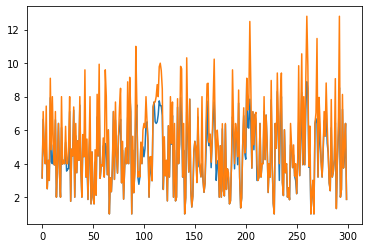

In [287]:
plt.plot(E_QS_vals)
plt.plot(E_CS_vals)

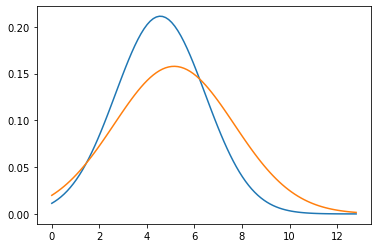

In [288]:
meanQ = np.mean(E_QS_vals)
meanC = np.mean(E_CS_vals)
stdQ = np.std(E_QS_vals)
stdC = np.std(E_CS_vals)
n = np.linspace(0,max(E_CS_vals),100)
QS_dist = 1/np.sqrt(2*np.pi*stdQ**2)*np.exp(-1*(n-meanQ)**2/(2*stdQ**2))
CS_dist = 1/np.sqrt(2*np.pi*stdC**2)*np.exp(-1*(n-meanC)**2/(2*stdC**2))
plt.plot(n,QS_dist,n,CS_dist)

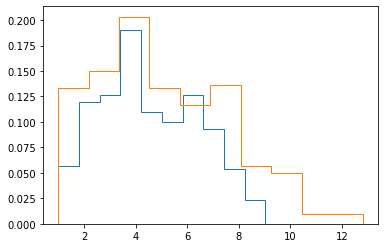

In [290]:
[countQ,binQ] = np.histogram(E_QS_vals,bins = 10)
[countC,binC] = np.histogram(E_CS_vals,bins = 10)
plt.stairs(countQ/Num_scrambles, binQ)
plt.stairs(countC/Num_scrambles, binC)

#plt.hist(E_CS_vals)